<a href="https://colab.research.google.com/github/doquyenduong/deep_learning_vision/blob/main/RNN_Town_Name_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 23 08:46:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import re
import string
import pandas as pd
from keras.layers import Dropout

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


In [ ]:
df = pd.read_csv("drive/MyDrive/Names/towns.csv",sep=";", encoding="ISO-8859-1")
#df["name"] = df["name"]+" "
df = df[["town"]].reset_index(drop=True)
df["town"] = df["town"]+" "
#df["abrv_street_name"] = df["abrv_street_name"]+" "
df.head()

,town
0,Aeugst am Albis
1,Affoltern am Albis
2,Bonstetten
3,Hausen am Albis
4,Hedingen


In [ ]:
dataset2 = tf.data.Dataset.from_tensor_slices((df))
dataset2

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.string, name=None)>

## Process the dataset

### Flatten the dataset

Converting the dataset from the set of articles into the set of characters. We also are interested only in `text` of each article so we may drop the `title` along the way.

In [ ]:
def article_to_text(text):
    return np.array([char for char in text.numpy().decode('utf-8')])

dataset_text = dataset2.map(
    lambda article: tf.py_function(func=article_to_text, inp=[article[0]], Tout=tf.string)
)

for text in dataset_text.take(2):
    print(text)
    print('\n')

tf.Tensor(
[b'A' b'e' b'u' b'g' b's' b't' b' ' b'a' b'm' b' ' b'A' b'l' b'b' b'i'
 b's' b' '], shape=(16,), dtype=string)


tf.Tensor(
[b'A' b'f' b'f' b'o' b'l' b't' b'e' b'r' b'n' b' ' b'a' b'm' b' ' b'A'
 b'l' b'b' b'i' b's' b' '], shape=(19,), dtype=string)




In [ ]:
# Unbatch the text dataset into a more granular char dataset.
# Now each dataset item is one character instead of a big piece of text.
dataset_chars = dataset_text.unbatch()

for char in dataset_chars.take(50):
    print(char.numpy().decode('utf-8'))

A
e
u
g
s
t
 
a
m
 
A
l
b
i
s
 
A
f
f
o
l
t
e
r
n
 
a
m
 
A
l
b
i
s
 
B
o
n
s
t
e
t
t
e
n
 
H
a
u
s


### Generating vocabulary

In [ ]:
vocab = set()

# Ideally we should take all dataset items into account here.
for text in dataset_chars:
    vocab.update(text.numpy().decode('utf-8'))
    
vocab = sorted(vocab)

print('Unique characters: {}'.format(len(vocab)))
print('vocab:')
print(vocab)

Unique characters: 67
vocab:
[' ', "'", '(', ')', '-', '.', '/', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'ä', 'è', 'é', 'ê', 'ë', 'ô', 'ö', 'ü']


In [ ]:
for text in dataset_chars.take(20):
  print(text)

tf.Tensor(b'A', shape=(), dtype=string)
tf.Tensor(b'e', shape=(), dtype=string)
tf.Tensor(b'u', shape=(), dtype=string)
tf.Tensor(b'g', shape=(), dtype=string)
tf.Tensor(b's', shape=(), dtype=string)
tf.Tensor(b't', shape=(), dtype=string)
tf.Tensor(b' ', shape=(), dtype=string)
tf.Tensor(b'a', shape=(), dtype=string)
tf.Tensor(b'm', shape=(), dtype=string)
tf.Tensor(b' ', shape=(), dtype=string)
tf.Tensor(b'A', shape=(), dtype=string)
tf.Tensor(b'l', shape=(), dtype=string)
tf.Tensor(b'b', shape=(), dtype=string)
tf.Tensor(b'i', shape=(), dtype=string)
tf.Tensor(b's', shape=(), dtype=string)
tf.Tensor(b' ', shape=(), dtype=string)
tf.Tensor(b'A', shape=(), dtype=string)
tf.Tensor(b'f', shape=(), dtype=string)
tf.Tensor(b'f', shape=(), dtype=string)
tf.Tensor(b'o', shape=(), dtype=string)


### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [ ]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(30)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  ' ' :   0,
  "'" :   1,
  '(' :   2,
  ')' :   3,
  '-' :   4,
  '.' :   5,
  '/' :   6,
  'A' :   7,
  'B' :   8,
  'C' :   9,
  'D' :  10,
  'E' :  11,
  'F' :  12,
  'G' :  13,
  'H' :  14,
  'I' :  15,
  'J' :  16,
  'K' :  17,
  'L' :  18,
  'M' :  19,
  'N' :  20,
  'O' :  21,
  'P' :  22,
  'Q' :  23,
  'R' :  24,
  'S' :  25,
  'T' :  26,
  'U' :  27,
  'V' :  28,
  'W' :  29,
  ...
}


In [ ]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)

print(index2char)

[' ' "'" '(' ')' '-' '.' '/' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' 'Z' 'a' 'b' 'c' 'd'
 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v'
 'w' 'x' 'y' 'z' 'â' 'ä' 'è' 'é' 'ê' 'ë' 'ô' 'ö' 'ü']


In [ ]:
def char_to_index(char):
    char_symbol = char.numpy().decode('utf-8')
    char_index = char2index[char_symbol] if char_symbol in char2index else char2index['?']
    return char_index

dataset_chars_indexed = dataset_chars.map(
    lambda char: tf.py_function(func=char_to_index, inp=[char], Tout=tf.int32)
)

print('ORIGINAL CHARS:', '\n---')
for char in dataset_chars.take(50):
    print(char.numpy().decode())

print('\n\n')    
    
print('INDEXED CHARS:', '\n---')
for char_index in dataset_chars_indexed.take(20):
    print(char_index.numpy())

ORIGINAL CHARS: 
---
A
e
u
g
s
t
 
a
m
 
A
l
b
i
s
 
A
f
f
o
l
t
e
r
n
 
a
m
 
A
l
b
i
s
 
B
o
n
s
t
e
t
t
e
n
 
H
a
u
s



INDEXED CHARS: 
---
7
36
52
38
50
51
0
32
44
0
7
43
33
40
50
0
7
37
37
46


In [ ]:
dataset_chars

<_UnbatchDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.string, name=None)>

In [ ]:
def char_to_index(char):
    char_symbol = char.numpy().decode('utf-8')
    char_index = char2index[char_symbol] if char_symbol in char2index else char2index['']
    return char_index

dataset_chars_indexed = dataset_chars.map(
    lambda char: tf.py_function(func=char_to_index, inp=[char], Tout=tf.int32)
)

for char in dataset_chars.take(20):
    print(char.numpy().decode('utf-8'))

A
e
u
g
s
t
 
a
m
 
A
l
b
i
s
 
A
f
f
o


## Create training sequences

In [ ]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 50

In [ ]:
# Generate batched sequences out of the char_dataset.
sequences = dataset_chars_indexed.batch(sequence_length + 1, drop_remainder=True)

# Sequences examples.
for item in sequences.take(10):
    print(repr(''.join(index2char[item.numpy()])))
    print()

'Aeugst am Albis Affoltern am Albis Bonstetten Hause'

'n am Albis Hedingen Kappel am Albis Knonau Maschwan'

'den Mettmenstetten Obfelden Ottenbach Rifferswil St'

'allikon Wettswil am Albis Adlikon Benken (ZH) Berg '

'am Irchel Buch am Irchel Dachsen Dorf Feuerthalen F'

'laach Flurlingen Andelfingen Henggart Humlikon Klei'

'nandelfingen Laufen-Uhwiesen Marthalen Ossingen Rhe'

'inau Thalheim an der Thur Trüllikon Truttikon Volke'

'n Bachenbülach Bassersdorf Bülach Dietlikon Eglisau'

' Embrach Freienstein-Teufen Glattfelden Hochfelden '



In [ ]:
# sequences shape:
# - Each sequence of length 101
#
#    201     201          201
# [(.....) (.....) ...  (.....)]

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
dataset_sequences = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset_sequences.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:\n', repr(''.join(index2char[input_example.numpy()])))
    print()
    print('Target:\n', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 50
Target sequence size: 50

Input:
 'Aeugst am Albis Affoltern am Albis Bonstetten Haus'

Target:
 'eugst am Albis Affoltern am Albis Bonstetten Hause'


In [ ]:
# dataset shape:
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#    200       200           200
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))
    print()

Step #0
  input: 7 ('A')
  expected output: 36 ('e')

Step #1
  input: 36 ('e')
  expected output: 52 ('u')

Step #2
  input: 52 ('u')
  expected output: 38 ('g')

Step #3
  input: 38 ('g')
  expected output: 50 ('s')

Step #4
  input: 50 ('s')
  expected output: 51 ('t')



## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 100

# How many items to prefetch before the next iteration.
PREFETCH_SIZE = 10

dataset_sequence_batches = dataset_sequences \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(PREFETCH_SIZE)

dataset_sequence_batches

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
for input_text, target_text in dataset_sequence_batches.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[49 50 54 ... 40 45 38]
 [45 40 38 ... 32 43 35]
 [45  4  8 ... 46 45  0]
 ...
 [32 44  0 ... 39 49 32]
 [ 0  9 39 ... 34 39  0]
 [51 54 40 ... 36 45 33]], shape=(64, 50), dtype=int32)

1st batch: target_text: tf.Tensor(
[[50 54 40 ... 45 38 36]
 [40 38 36 ... 43 35  0]
 [ 4  8 49 ... 45  0 10]
 ...
 [44  0 25 ... 49 32 43]
 [ 9 39 32 ... 39  0 25]
 [54 40 43 ... 45 33 32]], shape=(64, 50), dtype=int32)


In [ ]:
# dataset shape:
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     200       200           200             200       200           200
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[5 8 4 5 0 7 5 9]
 [8 1 3 1 1 1 4 0]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.02342174 -0.03617526 -0.01403851 -0.00586437  0.04123484]
  [-0.00112741 -0.02380614 -0.00467237 -0.02619611  0.04623104]
  [-0.00989401 -0.01192075  0.0336915   0.00625502  0.04550796]
  [ 0.02342174 -0.03617526 -0.01403851 -0.00586437  0.04123484]
  [ 0.00897555 -0.0073238  -0.01556813 -0.03762007  0.01182825]
  [-0.02189745 -0.03657757  0.01811261 -0.02399114 -0.04618346]
  [ 0.02342174 -0.03617526 -0.01403851 -0.00586437  0.04123484]
  [ 0.00957866 -0.0414855  -0.02294355  0.03912084  0.00523938]]

 [[-0.00112741 -0.02380614 -0.00467237 -0.02619611  0.04623104]
  [-0.03368393 -0.04151    -0.0248234   0.00326741  0.039419  ]
  [-0.02165328  0.01211119  0.03785961  0.01211242  0.0292351 ]
  [-0.03368393 -0.04151    -0.0248234   0.00326741  0.039419  ]
  [-0.03368393 -0.04151    -0.0248234   0.00326741  0.039419  ]
  [-0.03368393 -0.04151    

In [ ]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(Dropout(0.2))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           17152     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dense (Dense)               (64, None, 67)            68675     
                                                                 
Total params: 13,725,507
Trainable params: 13,725,507
Non-trainable params: 0
_________________________________________________________________


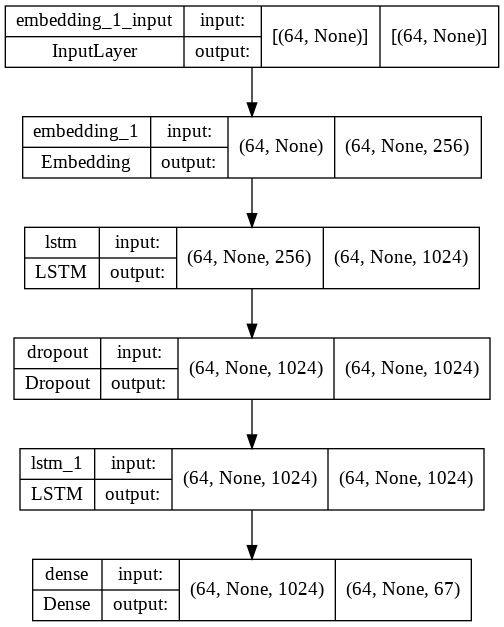

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

#example_batch_loss = loss(target_example_batch, example_batch_predictions)

#print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
#print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [ ]:
# %rm -rf tmp/checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'drive/MyDrive/RNN-town'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [ ]:
EPOCHS=100
STEPS_PER_EPOCH = 10

In [ ]:
tmp_dataset = dataset_sequence_batches.repeat()
    
history = model.fit(
    x=tmp_dataset.as_numpy_iterator(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        checkpoint_callback
    ]
)

Epoch 1/100
10/10 [==============================] - 19s 732ms/step - loss: 3.6519
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 3.3922
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 3.3560
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 3.2552
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 3.1453
Epoch 6/100
10/10 [==============================] - 10s 1s/step - loss: 2.8824
Epoch 7/100
10/10 [==============================] - 15s 1s/step - loss: 2.6988
Epoch 8/100
10/10 [==============================] - 13s 1s/step - loss: 2.6090
Epoch 9/100
10/10 [==============================] - 10s 1s/step - loss: 2.5261
Epoch 10/100
10/10 [==============================] - 14s 1s/step - loss: 2.4359
Epoch 11/100
10/10 [==============================] - 13s 1s/step - loss: 2.4073
Epoch 12/100
10/10 [==============================] - 11s 1s/step - loss: 2.3428
Epoch 13/100
10/10 [==============

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

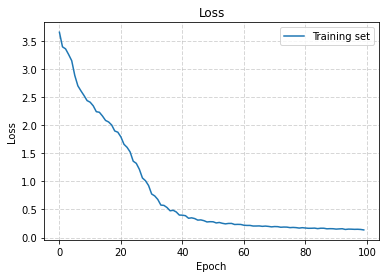

In [ ]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'drive/MyDrive/RNN-town/ckpt_100'

In [ ]:
simplified_batch_size = 1

restored_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

restored_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

restored_model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
restored_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            17152     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_1 (Dropout)         (1, None, 1024)           0         
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dense_1 (Dense)             (1, None, 67)             68675     
                                                                 
Total params: 13,725,507
Trainable params: 13,725,507
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
#temperatures = [0.1, 0.2, 0.3, 0.4, 0.5]
start_string = ''

for temperature in temperatures:
    print("Temperature: {}".format(temperature))
    print('---')
    print(generate_text(restored_model, start_string, num_generate=num_generate, temperature=temperature))
    print('\n')

Temperature: 0.2
---


InvalidArgumentError: ignored

In [ ]:
result = generate_text(restored_model, " ", num_generate=10000, temperature=1.0)

In [ ]:
result = result.replace(" ",",")

In [ ]:
result_df = pd.DataFrame(list(result.split(",")))
result_df

,0
0,
1,Mümliswil-Ramiswil
2,Welschenrohr-Gänsbrunnen
3,Biezwil
4,Engelberg
...,...
1098,Eggenwil
1099,Fischbach-Gösl
1100,Reigoldswil
1101,Titterten


In [ ]:
result_df.to_csv("generated_towns.csv",index=False)

## Save the model

In [ ]:
model_name = 'text_generation_town_names_rnn.h5'
restored_model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_wikipedia_rnn/text_generation_wikipedia_rnn.h5 \
  ./demos/public/models/text_generation_wikipedia_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.